**First load and check the data integrity :-**

In [16]:
from test_helper import Test
import os.path
base=os.path.join('data')
path=os.path.join('cs190','millionsong.txt')
fname=os.path.join(base,path)

partition=2
data=sc.textFile(fname,partition)

**Count all the data points and load some examples to check the data points :-** 

In [17]:
datapoints=data.count()
print datapoints
examplepoints=data.take(5)
print examplepoints

6724
[u'2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817', u'2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624', u'2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818', u'2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173', u'2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.463373691946']


In [18]:
#Test the results :- 
Test.assertEquals(datapoints,6724, 'Value doesnt match, check the code or data sheet again to find a solution')
Test.assertEquals(len(examplepoints),5,'Mistmatch found, check the length specified again.')

1 test passed.
1 test passed.


In [19]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

**Sample Raw Data**
#### '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
#### This Raw data point represents 2001 label and other values are features.
#### Convert a comma separated unicode into 'LabeledPoint'

#### In MLlib LabelPoint instances are used for training instances. convertRaw  takes Raw Data as input and parses it using unicode split() method. Finally first training point is printed

In [20]:
def convertRaw(line):
    tokens = line.split(',')
    label,features = tokens[0], tokens[1:]
    return LabeledPoint(label,features)

parsedpoints = [convertRaw(points) for points in examplepoints]

firstpointfeatures = parsedpoints[0].features
firstpointlabel = parsedpoints[0].label
print firstpointfeatures, firstpointlabel


no=len(firstpointfeatures)
print no

[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0
12


#### Test module for Labeled Points

In [21]:
Test.assertTrue(isinstance(firstpointlabel,float),'label will be a float')
first=[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817]
#Test.assertTrue(np.allclose(first,firstpointfeatures),'Wrong features for first point')
Test.assertTrue(np.allclose(2001.0,firstpointlabel),'wrong label')
Test.assertTrue( no == 12,'Features missing')

1 test passed.
1 test passed.
1 test passed.


**Visualization Features**
#### 1) Setup and implement Visualizing library
#### 2) Load a heatmap for first 50 data points.

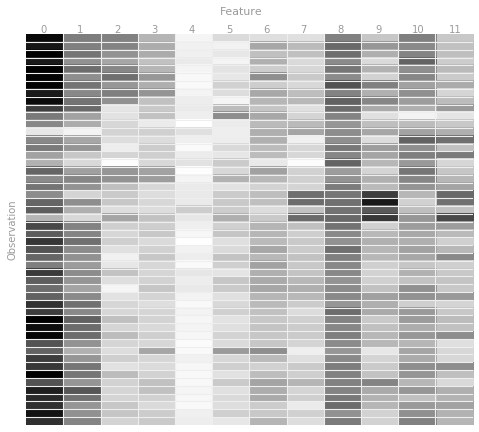

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sample = data.take(50)

parsesample = map(convertRaw, sample)
dataVal=map(lambda x: x.features.toArray(),parsesample)

def prepplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

fig, ax = prepplot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True, gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataVal,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
plt.show()
pass


#### The heatmap shows the variance seen in the range of attribute value.

**Find the range of the data set**

In [23]:
parsedDataInit = data.map(convertRaw)
onLabels = parsedDataInit.map(lambda X: X.label).collect()
minY = min(onLabels)
maxY = max(onLabels)
print maxY, minY

2011.0 1922.0


In [24]:
Test.assertEquals(len(parsedDataInit.take(1)[0].features), 12,'unexpected number of features in sample point')
yearRange = maxY - minY
Test.assertTrue(yearRange == 89, 'incorrect range for minYear to maxYear')

1 test passed.
1 test passed.


**Shift labels to origin**

In [25]:
parsD=parsedDataInit.map(lambda x: LabeledPoint(x.label-minY,x.features))
print type(parsD.take(1)[0])
print '\n{0}'.format(parsD.take(1))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])]


In [26]:
oldSampleFeatures = parsedDataInit.take(1)[0].features
newSampleFeatures = parsD.take(1)[0].features
Test.assertTrue(np.allclose(oldSampleFeatures, newSampleFeatures),'new features do not match old features')
minYNew = parsD.map(lambda x: x.label).min()
maxYNew = parsD.map(lambda x: x.label).max()
Test.assertTrue(minYNew == 0, 'incorrect min year in shifted data')
Test.assertTrue(maxYNew == 89, 'incorrect max year in shifted data')

1 test passed.
1 test passed.
1 test passed.


**Visualize the data using scatterplot for both old Sample points and new Sample points (Shifted)**

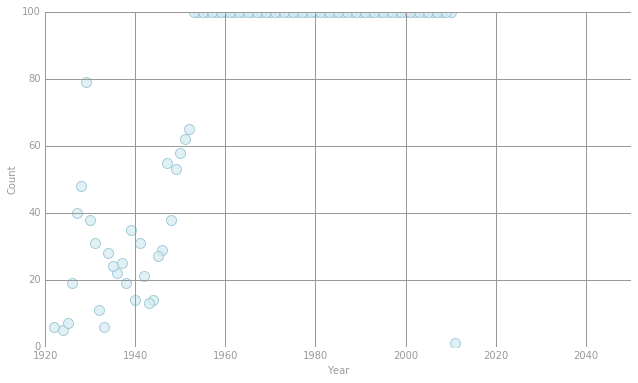

In [27]:
#get the data for plotting
Odat=(parsedDataInit.map(lambda x:(x.label,1)).reduceByKey(lambda x, y: x + y).collect())
x,y = zip(*Odat)
#plot the data
fig, ax = prepplot(np.arange(1920, 2050, 20), np.arange(0, 120, 20))
ax.set_ylim(0, 100)
ax.set_xlim(1920,2050)
plt.scatter(x, y,s=10**2, c="#d6ebf2", edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
plt.show()
pass

#### A simple scatterplot depicting the count of songs in a given year

#### From here we can visualize the range of years in our dataset. 

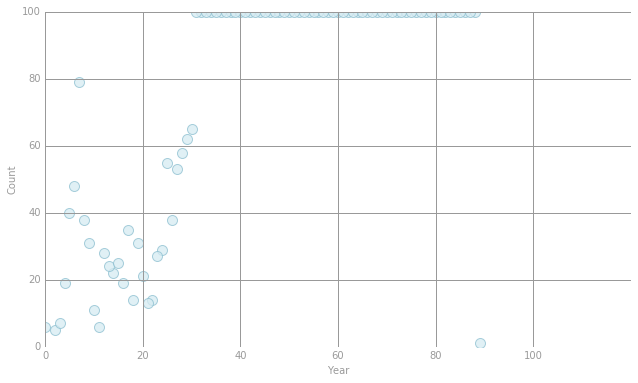

In [28]:
#get the data for plotting
Ndat=(parsD.map(lambda x:(x.label,1)).reduceByKey(lambda x, y: x + y).collect())
x,y = zip(*Ndat)
#plot the data
fig, ax = prepplot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_ylim(0, 100)
ax.set_xlim(0, 120)
plt.scatter(x, y,s=10**2, c="#d6ebf2", edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
plt.show()
pass

#### This second scatterplot depicts the count of songs in a given year where the years have been shifted to origin.

#### From here we can visualize the range of years in our dataset.


**Defining Training, Validation and Test sets:**

**We finished parsing the data set and now we need to define sets for training, validation and test sets using randomSplit method and create RDDs which store these dataset. Caching these will significantly increase performance.**


In [29]:
w=[.8, .1, .1]
s=42
#ptrd=Training set
#pvd=Validation set
#pted=Test set
ptrd,pvd,pted = parsD.randomSplit(w, s)
ptrd.cache()
pvd.cache()
pted.cache()
noOfTrain = ptrd.count()
noOfVal = pvd.count()
noOfTest = pted.count()

print noOfTrain, noOfVal, noOfTest, noOfTrain + noOfVal + noOfTest
print parsD.count()

5371 682 671 6724
6724


In [30]:
Test.assertEquals(ptrd.getNumPartitions(), partition,'ptrd has wrong number of partitions')
Test.assertEquals(pvd.getNumPartitions(), partition,'pvd has wrong number of partitions')
Test.assertEquals(pted.getNumPartitions(), partition,'pted has wrong number of partitions')
#Test.assertEquals(len(ptrd.take(1)[0].features), 12,'ptrd has wrong number of features')
Test.assertTrue(noOfTrain + noOfVal + noOfTest == 6724, 'Error in Train, Val, Test data set size')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### ** Create a baseline model and evaluate :- **

**Simplest baseline model approach - Find mean**

In [31]:
meanYr = (ptrd.map(lambda x: x.label).mean())
print meanYr

53.9316700801


In [32]:
Test.assertTrue(np.allclose(meanYr, 53.9316700801),'incorrect value for averageTrainYear')

1 test passed.


**Using RMSE to evaluate our baseline model**

In [33]:
#Defining function for RMSE and running a test dummy
def sqer(label, prediction):
    return (label - prediction) ** 2

def calculateRMSE(lp):
    return np.sqrt(lp.map(lambda (label, prediction): sqer(label, prediction)).mean())

lp= sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
RMSEval = calculateRMSE(lp)
print RMSEval

1.29099444874


In [34]:
Test.assertTrue(np.allclose(sqer(3, 1), 4.), 'incorrect definition of squaredError')
Test.assertTrue(np.allclose(RMSEval, 1.29099444874), 'incorrect value for exampleRMSE')

1 test passed.
1 test passed.


In [35]:
lptr=ptrd.map(lambda x:(x.label,meanYr))
RMSEtr=calculateRMSE(lptr)

lpv=pvd.map(lambda x:(x.label,meanYr))
RMSEv=calculateRMSE(lpv)

lpte=pted.map(lambda x:(x.label,meanYr))
RMSEte=calculateRMSE(lpte)

print 'Baseline Train RMSE = %f'%RMSEtr
print 'Baseline Validation RMSE = %f'%RMSEv
print 'Baseline Test RMSE = %f'%RMSEte

Baseline Train RMSE = 21.305869
Baseline Validation RMSE = 21.586452
Baseline Test RMSE = 22.136957


In [36]:
Test.assertTrue(np.allclose([RMSEtr, RMSEv, RMSEte],[21.305869, 21.586452, 22.136957]), 'incorrect RMSE value')

1 test passed.


### **Visualization of prediction on the validation dataset **

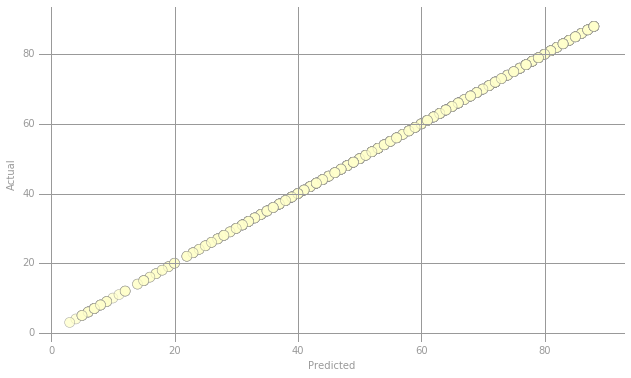

In [37]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

act = np.asarray(pvd.map(lambda x: x.label).collect())
err = np.asarray(pvd.map(lambda x: (x.label, x.label)).map(lambda (a, b): sqer(a, b)).collect())
clrs = cmap(np.asarray(norm(err)))[:,0:3]

fig, ax = prepplot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(act, act, s=10**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
plt.show()
pass

**This scatter plot represents the ideal situation where the predicted value exactly equals the true label.**

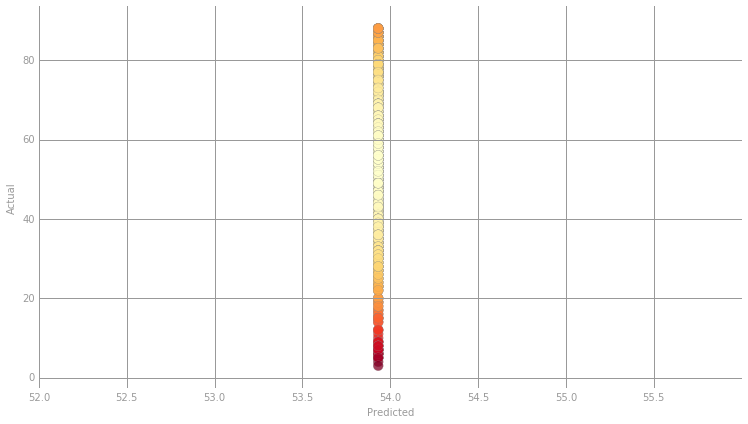

In [38]:
pred = np.asarray(pvd.map(lambda x: meanYr).collect())
err = np.asarray(pvd.map(lambda x: (x.label, meanYr)).map(lambda (a, b): sqer(a, b)).collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(err)))[:,0:3]

fig, ax = prepplot(np.arange(52.0, 56.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(52.0, 56.0)
plt.scatter(pred, act, s=10**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()
pass

** ▪ This scatter plot uses Baseline Prediction Model (Average Trained Year). **

** ▪ Also, the points in the scatter plots are color-coded, ranging from light
  yellow when they are true and predicted values are equal to bright red when
  they drastically differ. **

### **Train and evaluate a linear regression model**

#### We will train a model using gradient descent method. 

#### Gradient descent is used to find the minimum error by minimizing a "cost" function.

#### The gradient descent update for linear regression is: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ where $ \scriptsize i $ is the iteration number of the gradient descent algorithm, and $ \scriptsize j $ identifies the observation.

#### Implement a function to calculate gradient summand and test out the functionality with dummy examples.


In [39]:
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LabeledPoint

In [40]:
def gradientfunc(weights,lp):
    #weights=An Array of model weights
    #lp=Labeled Point for a single point
    #Calculate and return  the gradient summand.
    return (weights.dot(lp.features) - lp.label) * lp.features

dummyW=DenseVector([1,1,1])
dummyLP=LabeledPoint(2.0,[3,1,4])
# gradientSummand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
dummysummand = gradientfunc(dummyW, dummyLP)
print dummysummand

[18.0,6.0,24.0]


In [41]:
# Testing Gradient summand 
Test.assertTrue(np.allclose(dummysummand, [18., 6., 24.]), 'incorrect value for dummysummand')

1 test passed.


#### Now implement a function that takes in weights and an observation's LabeledPoint and returns a (label, prediction) tuple. 
#### We can predict by computing the dot product between weights and an observation's features.

In [42]:
def getLabeledPrediction(weights, observation):
        #weights (np.ndarray): An array with one weight for each features in `trainData`.
        #observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the features for the data point.
        #Returns: A (label, prediction)    
    return (observation.label, weights.dot(observation.features))

weights = np.array([1.0, 1.5])
dummypred = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),LabeledPoint(1.5, np.array([.5, .5]))])
dummylabelsandpred = dummypred.map(lambda lp: getLabeledPrediction(weights, lp))
print dummylabelsandpred.collect()

[(2.0, 1.75), (1.5, 1.25)]


In [43]:
# Test for predictions function 
Test.assertEquals(dummylabelsandpred.collect(), [(2.0, 1.75), (1.5, 1.25)],'incorrect definition for getLabeledPredictions')

1 test passed.


#### Now implement a gradient descent function for linear regression and test out using a dummy example.

In [44]:
def GradientDescent(trainData, numIters):
    #trainData: The labeled data for use in training the model.
    #numIters: The number of iterations of gradient descent to perform.
    length=trainData.count()
    nooffeature = len(trainData.take(1)[0].features)
    w = np.zeros(nooffeature)
    alpha = 1.0
    trainingerrors = np.zeros(numIters) #store training errors
    for i in range(numIters):
        #Use getLabeledPrediction with trainData to obtain an RDD of (label, prediction).
        laptrain = trainData.map(lambda x: getLabeledPrediction(w, x))
        trainingerrors[i] = calculateRMSE(laptrain)
        #Use the gradient function to calculate the gradient.
        gradient = trainData.map(lambda x: gradientfunc(w, x)).sum()
        #Update the weights
        alphai = alpha / (length * np.sqrt(i+1))
        w -= alphai * gradient
        #Returns: A tuple of (weights, training errors).
    return w, trainingerrors

dummyN = 10
dummyD = 3
dummyData = (sc.parallelize(ptrd.take(dummyN)).map(lambda lp: LabeledPoint(lp.label, lp.features[0:dummyD])))
print dummyData.take(2)
dummyNumIters = 5
dummyWeights, dummyErrorTrain = GradientDescent(dummyData, dummyNumIters)
print dummyWeights

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968]), LabeledPoint(79.0, [0.854411946129,0.604124786151,0.593634078776])]
[ 48.88110449  36.01144093  30.25350092]


In [45]:
expectedOutput = [48.88110449,36.01144093,30.25350092]
Test.assertTrue(np.allclose(dummyWeights, expectedOutput), 'value of dummyWeights is incorrect')
expectedError = [79.72013547,30.27835699,9.27842641,9.20967856,9.19446483]
Test.assertTrue(np.allclose(dummyErrorTrain, expectedError),'value of dummyErrorTrain is incorrect')

1 test passed.
1 test passed.


### **Now Training the model**

**Now train a linear regression model on all of the training data set and evaluate its accuracy on the validation set.**

In [46]:
numIters = 50
#w=weigths
#eT=Error in Training
w, eT = GradientDescent(ptrd, numIters)
print w
lap = pvd.map(lambda x: getLabeledPrediction(w, x)) #labels and predictions
#print lap.collect()
rmseval = calculateRMSE(lap)
print 'Validation RMSE:\n\tBaseline = {0:.3f}\n\t GD = {1:.3f}'.format(RMSEv,rmseval)

[ 22.64535883  20.064699    -0.05341901   8.2931319    5.79155768
  -4.51008084  15.23075467   3.8465554    9.91992022   5.97465933
  11.36849033   3.86452361]
Validation RMSE:
	Baseline = 21.586
	 GD = 19.192


In [47]:
# TEST Train the model (3d)
expectedOutput = [22.64535883, 20.064699, -0.05341901, 8.2931319, 5.79155768, -4.51008084,15.23075467, 3.8465554, 9.91992022, 5.97465933, 11.36849033, 3.86452361]
#Test.assertTrue(np.allclose(w, expectedOutput), 'Wrong weight outcome')

**Now Visualize the log of the training error as a function of iteration.**

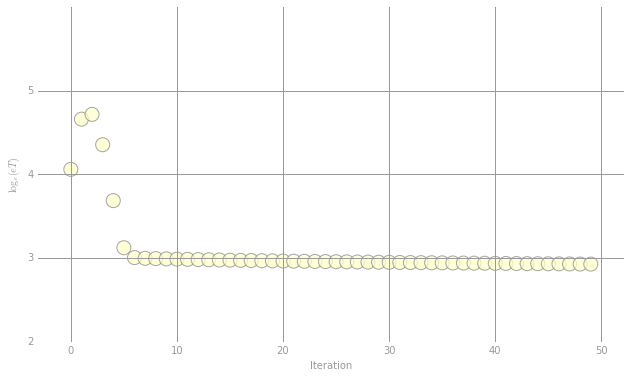

In [48]:
n = Normalize()
clrs = cmap(np.asarray(norm(np.log(eT))))[:,0:3]

fig, ax = prepplot(np.arange(0, 60, 10), np.arange(2, 6, 1))
plt.scatter(range(0, numIters), np.log(eT), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_ylim(2, 6)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(eT)$')
plt.show()
pass

**▪ This scatter plot shows log of Training Error as a function of Iteration. **

**▪ Significant reduction of error can be observed. **

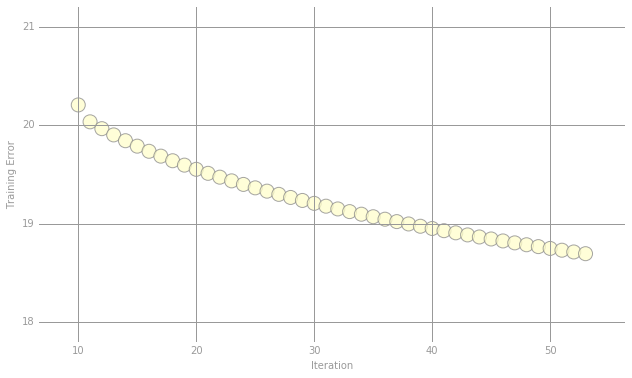

In [49]:
n = Normalize()
clrs = cmap(np.asarray(norm(eT[6:])))[:,0:3]

fig, ax = prepplot(np.arange(0, 100, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, numIters-6), eT[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(10, 100, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
plt.show()
pass

**▪ This scatter plot shows Training Error as a function of Iteration. **

**▪ Errors reduce as the number of iterations are increased to calculate more appropriate or accurate weights for Gradient Descent algorithm. **

In [50]:
#Lets check predictions made by GD
print "[(Actual Year, Predicted Year)]"
lap.collect()

[(Actual Year, Predicted Year)]


[(79.0, 64.012682471741257),
 (86.0, 48.282734919171631),
 (75.0, 54.116404880631514),
 (78.0, 51.54804654505817),
 (74.0, 57.518518303770023),
 (75.0, 55.28815806272479),
 (81.0, 56.829507104216006),
 (85.0, 68.282897679980849),
 (87.0, 60.895714207186032),
 (86.0, 58.559692311764771),
 (86.0, 56.675278066757507),
 (86.0, 60.751228374652534),
 (85.0, 50.475291742844107),
 (85.0, 59.312994427927222),
 (85.0, 56.169742184902148),
 (85.0, 55.290328832696147),
 (82.0, 58.07220190575373),
 (87.0, 64.173261247262474),
 (87.0, 60.017401701374858),
 (71.0, 52.883328119172731),
 (71.0, 53.239308559946366),
 (69.0, 43.058007026229291),
 (77.0, 44.421228700343576),
 (69.0, 41.7384499867185),
 (78.0, 50.357069933558925),
 (78.0, 58.936925513747035),
 (78.0, 53.225850387503236),
 (85.0, 55.492080654141283),
 (86.0, 57.783169287133781),
 (77.0, 55.693799975540379),
 (77.0, 48.936549570886562),
 (83.0, 60.862619323656318),
 (84.0, 57.635621474837002),
 (84.0, 59.105403689618363),
 (83.0, 56.52631564

#### Lets try to implement LinearRegressionWithSGD to see if we can outperform previous prediction
    SGD = Stochastic Gradient Descent
    We will use L2 Regularization with an Intercept.

In [51]:
from pyspark.mllib.regression import LinearRegressionWithSGD
numberofIterations=700
step_value=1.0 
batchdiv=1.0
param=1e-1
regularization='l2'
Intercept_pres= True

In [52]:
tryout=LinearRegressionWithSGD.train(ptrd, iterations=numberofIterations, step=step_value, miniBatchFraction=batchdiv, initialWeights=None, regParam=param, regType=regularization, intercept=Intercept_pres)
temp_weights=tryout.weights
temp_intercept=tryout.intercept
print temp_weights,temp_intercept


/home/asheleon/spark-2.2.0-bin-hadoop2.7/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[15.9789216525,13.923582484,0.781551054803,6.09257051566,3.91814791179,-2.30347707767,10.3002026917,3.04565129011,7.23175674717,4.65796458476,7.98875075855,3.1782463856] 13.3763009811


In [53]:
outputI = 13.3763009811
outputW = [15.9789216525,13.923582484,0.781551054803,6.09257051566,3.91814791179,-2.30347707767,10.3002026917,3.04565129011,7.23175674717,4.65796458476,7.98875075855,3.1782463856]
#Test.assertTrue(np.allclose(temp_weights, outputW), 'Wrong intercept')
#Test.assertTrue(np.allclose(temp_intercept, outputI), 'Wrong weights')

#### Use prediction method of the library to check sample.

In [54]:
testrunpoint = ptrd.take(1)[0]
testrunpred = tryout.predict(testrunpoint.features)
print testrunpred

56.5823796609


In [55]:
Test.assertTrue(np.allclose(testrunpred, 56.5823796609), 'incorrect value for samplePrediction')

1 test passed.


#### Evaluate RMSE

In [56]:
calculate = pvd.map(lambda lp: (lp.label, tryout.predict(lp.features)))
rmv = calculateRMSE(calculate)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tGD = {1:.3f}'+'\n\tSGD = {2:.3f}').format(RMSEv,rmseval,rmv)

Validation RMSE:
	Baseline = 21.586
	GD = 19.192
	SGD = 19.873


In [57]:
Test.assertTrue(np.allclose(rmv, 19.873), 'Wrong value')

1 test passed.


#### Use grid search to find regularization parameter

In [58]:
testcaseRMSE = rmv
testcaseparam = param
testcaseModel = tryout

n=500
s=1.0
bat=1.0
for param in [1e-10, 1e-5, 1.0]:
    mod = LinearRegressionWithSGD.train(ptrd,n,s,bat,regParam=param, regType='l2', intercept=True)
    labs = pvd.map(lambda lp: (lp.label, mod.predict(lp.features)))
    rmseVG = calculateRMSE(labs)
    print rmseVG

    if rmseVG < testcaseRMSE:
        testcaseRMSE = rmseVG
        testcaseparam = param
        testcasemodel = mod
rmseVG = testcaseRMSE

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tGD = {1:.3f}\n\tSGD = {2:.3f}\n' +
       '\tSGD with Grid Search = {3:.3f}').format(RMSEv,rmseval,rmv, rmseVG)

17.4831362704
17.4834818658
23.8000672935
Validation RMSE:
	Baseline = 21.586
	GD = 19.192
	SGD = 19.873
	SGD with Grid Search = 17.483


In [59]:
Test.assertTrue(np.allclose(17.483,rmseVG), 'Wrong value')

1 test passed.


#### Finally visulaize the prediction of experimented model

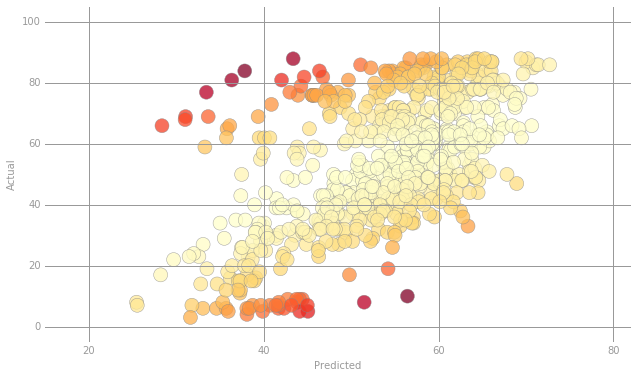

In [60]:
pred = np.asarray(pvd.map(lambda lp: testcasemodel.predict(lp.features)).collect())
act = np.asarray(pvd.map(lambda lp: lp.label).collect())
err = np.asarray(pvd.map(lambda lp: (lp.label, testcasemodel.predict(lp.features)))
                   .map(lambda (l, p): sqer(l, p)).collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(err)))[:,0:3]

fig, ax = prepplot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(pred, act, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
plt.show()
pass

**▪ Stochastic Gradient Descent without good regularization parameter
decision doesn’t perform so well in comparison to Vanilla Gradient
Descent.**

**▪ With Grid Search implementation on SGD we are significantly able to
reduce the Root Mean Square Error.**

**▪ A color-coded scatter plot visualizing the predicted value from this model
against true label.**

In [61]:
findreg = testcaseparam
arrRMSE = []

for s in [1e-5, 10]:
    for n in [500, 5]:
        mod = LinearRegressionWithSGD.train(ptrd, n, s,bat, regParam=findreg, regType='l2', intercept=True)
        lapas = pvd.map(lambda lp: (lp.label, mod.predict(lp.features)))
        rmsevl = calculateRMSE(lapas)
        print 'Step = {0:.0e}, Iteration numbers = {1}, RMSE = {2:.3f}'.format(s, n, rmsevl)
        arrRMSE.append(rmsevl)

Step = 1e-05, Iteration numbers = 500, RMSE = 56.973
Step = 1e-05, Iteration numbers = 5, RMSE = 56.973


/home/asheleon/spark-2.2.0-bin-hadoop2.7/python/pyspark/statcounter.py:83: RuntimeWarning: overflow encountered in double_scalars
  self.m2 += other.m2 + (delta * delta * self.n * other.n) / (self.n + other.n)


Step = 1e+01, Iteration numbers = 500, RMSE = 33110728225679002898243535475370381153231748093308519592022542725707151441177139778832831219138213677907418329889500037120.000
Step = 1e+01, Iteration numbers = 5, RMSE = 355124752.221


In [62]:
res = sorted([56.973, 56.973, 355124752.221])
Test.assertTrue(np.allclose(sorted(arrRMSE)[:3], res), 'Wrong value observed in arrRMSE')

1 test passed.


#### Predefined heat map generation to find the best number of iteration and accurate regularization parameter to find lowest RMSE value which is indicated by brighter region.

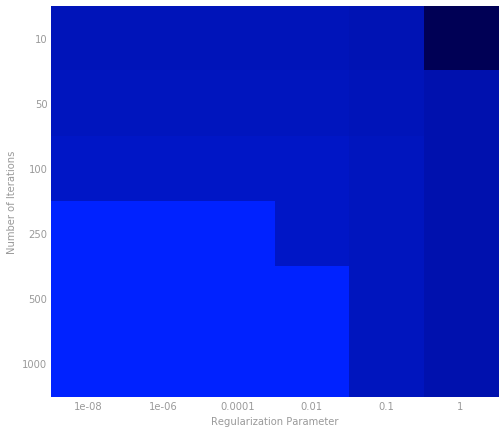

In [63]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = prepplot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')
colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto', cmap = colors)
plt.show()

**•The plot represents a heat map where the brighter colors correspond to lower
RMSE values for regularization parameter against No. of Iterations.**

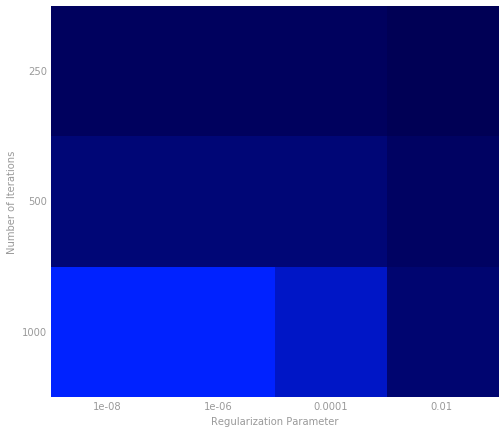

In [64]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = prepplot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',cmap = colors)
plt.show()
pass

** The figure shows a deeper insight as to what significantly is a better choice of regularization parameters, which is hard to disntiguish in the above figure after a certain range.**

#### Finally evaluate the final model on test data

In [65]:
TEST = pted.map(lambda lp: (lp.label, tryout.predict(lp.features)))
Testrmse = calculateRMSE(TEST)

print ('Test RMSE:\n\tBaseline = {0:.3f}\n\tSGD with Grid Search = {1:.3f}'.format(RMSEte, Testrmse))

Test RMSE:
	Baseline = 22.137
	SGD with Grid Search = 20.010


In [66]:
Test.assertTrue(np.allclose(Testrmse, 20.010),'incorrect value for rmseTestInteract')

1 test passed.


#### 2 Way Interaction can be explored to find a better model. 

In [67]:
#Lets check some predictions made by SGD with Grid Search
print "SGD with Grid search"
print "[(Actual Year, Predicted Year)]"
pred = pvd.map(lambda lp: (lp.label, testcasemodel.predict(lp.features)))
pred.collect()

SGD with Grid search
[(Actual Year, Predicted Year)]


[(79.0, 66.979192439969637),
 (86.0, 51.079078957401045),
 (75.0, 53.215409470077866),
 (78.0, 47.182866002502962),
 (74.0, 62.610896259949996),
 (75.0, 57.670637368922122),
 (81.0, 61.316617894773685),
 (85.0, 70.777697467811194),
 (87.0, 63.289753166719763),
 (86.0, 60.946147049598785),
 (86.0, 58.51072998774702),
 (86.0, 63.639651712383611),
 (85.0, 52.255094544479988),
 (85.0, 58.22944478840828),
 (85.0, 56.269289053357696),
 (85.0, 56.004772199882012),
 (82.0, 59.478245404605616),
 (87.0, 69.991373677335204),
 (87.0, 62.220673360886913),
 (71.0, 54.327802451160636),
 (71.0, 55.584463454395845),
 (69.0, 33.651472118985254),
 (77.0, 33.442874495677515),
 (69.0, 31.065916862913099),
 (78.0, 54.341285277521884),
 (78.0, 59.132618007613878),
 (78.0, 57.14593751884842),
 (85.0, 57.854809711351969),
 (86.0, 63.686311990024066),
 (77.0, 57.874599367498497),
 (77.0, 48.470825626595236),
 (83.0, 64.421746030545663),
 (84.0, 62.706477399192011),
 (84.0, 65.80273074483766),
 (83.0, 62.0933272

In [68]:
#Lets check predictions made by SGD
print "SGD"
print "[(Actual Year, Predicted Year)]"
calculate.collect()

SGD
[(Actual Year, Predicted Year)]


[(79.0, 59.684788547050466),
 (86.0, 48.476723900233658),
 (75.0, 52.84780329733281),
 (78.0, 51.175268850499663),
 (74.0, 54.93294687567456),
 (75.0, 53.446519464793049),
 (81.0, 54.474636171932296),
 (85.0, 62.675938763444407),
 (87.0, 57.503794559764756),
 (86.0, 55.754079285057792),
 (86.0, 54.439951261773146),
 (86.0, 57.361047360708355),
 (85.0, 50.070502360737827),
 (85.0, 56.566568467312578),
 (85.0, 54.244234860633469),
 (85.0, 53.631707077438165),
 (82.0, 55.594590988069072),
 (87.0, 59.561359806307763),
 (87.0, 56.890711902396426),
 (71.0, 51.753023375287093),
 (71.0, 51.967507049770603),
 (69.0, 45.552156860175089),
 (77.0, 46.565962124723313),
 (69.0, 44.637467645590057),
 (78.0, 49.818705550274345),
 (78.0, 56.229282653476382),
 (78.0, 51.878515166928644),
 (85.0, 53.594609594731892),
 (86.0, 55.019567560719651),
 (77.0, 53.745482541267442),
 (77.0, 49.017721195261728),
 (83.0, 57.450347839724259),
 (84.0, 55.027542539678755),
 (84.0, 55.966301163741193),
 (83.0, 54.13456

In [69]:
#Lets check predictions made by GD
print "GD"
print "[(Actual Year, Predicted Year)]"
lap.collect()

GD
[(Actual Year, Predicted Year)]


[(79.0, 64.012682471741257),
 (86.0, 48.282734919171631),
 (75.0, 54.116404880631514),
 (78.0, 51.54804654505817),
 (74.0, 57.518518303770023),
 (75.0, 55.28815806272479),
 (81.0, 56.829507104216006),
 (85.0, 68.282897679980849),
 (87.0, 60.895714207186032),
 (86.0, 58.559692311764771),
 (86.0, 56.675278066757507),
 (86.0, 60.751228374652534),
 (85.0, 50.475291742844107),
 (85.0, 59.312994427927222),
 (85.0, 56.169742184902148),
 (85.0, 55.290328832696147),
 (82.0, 58.07220190575373),
 (87.0, 64.173261247262474),
 (87.0, 60.017401701374858),
 (71.0, 52.883328119172731),
 (71.0, 53.239308559946366),
 (69.0, 43.058007026229291),
 (77.0, 44.421228700343576),
 (69.0, 41.7384499867185),
 (78.0, 50.357069933558925),
 (78.0, 58.936925513747035),
 (78.0, 53.225850387503236),
 (85.0, 55.492080654141283),
 (86.0, 57.783169287133781),
 (77.0, 55.693799975540379),
 (77.0, 48.936549570886562),
 (83.0, 60.862619323656318),
 (84.0, 57.635621474837002),
 (84.0, 59.105403689618363),
 (83.0, 56.52631564

In [70]:
#Now lets check Average Model predictions
print "Average Model"
print "[(Actual Year, Predicted Year)]"
lpv.collect()

Average Model
[(Actual Year, Predicted Year)]


[(79.0, 53.931670080059654),
 (86.0, 53.931670080059654),
 (75.0, 53.931670080059654),
 (78.0, 53.931670080059654),
 (74.0, 53.931670080059654),
 (75.0, 53.931670080059654),
 (81.0, 53.931670080059654),
 (85.0, 53.931670080059654),
 (87.0, 53.931670080059654),
 (86.0, 53.931670080059654),
 (86.0, 53.931670080059654),
 (86.0, 53.931670080059654),
 (85.0, 53.931670080059654),
 (85.0, 53.931670080059654),
 (85.0, 53.931670080059654),
 (85.0, 53.931670080059654),
 (82.0, 53.931670080059654),
 (87.0, 53.931670080059654),
 (87.0, 53.931670080059654),
 (71.0, 53.931670080059654),
 (71.0, 53.931670080059654),
 (69.0, 53.931670080059654),
 (77.0, 53.931670080059654),
 (69.0, 53.931670080059654),
 (78.0, 53.931670080059654),
 (78.0, 53.931670080059654),
 (78.0, 53.931670080059654),
 (85.0, 53.931670080059654),
 (86.0, 53.931670080059654),
 (77.0, 53.931670080059654),
 (77.0, 53.931670080059654),
 (83.0, 53.931670080059654),
 (84.0, 53.931670080059654),
 (84.0, 53.931670080059654),
 (83.0, 53.931